In [29]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [22]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['hus','va'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,day,hus,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815
1,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,day,va,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815


In [23]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


`intake-esm` is build on top of [pandas](https://pandas.pydata.org/pandas-docs/stable). It is possible to view the `pandas.DataFrame` as follows.

In [24]:
dataset_list = list(dset_dict.keys())
dataset_list

['CMIP.NCC.NorESM2-LM.historical.day.gn']

In [25]:
dset = dset_dict[dataset_list[0]]
dset = dset.sel(member_id='r1i1p1f1',time=slice("2000-01-01", "2014-12-31"))
dset

<xarray.Dataset>
Dimensions:    (lat: 96, lon: 144, plev: 8, time: 5475, bnds: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * time       (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00
    member_id  <U8 'r1i1p1f1'
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(5475, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    hus        (time, plev, lat, lon) float32 dask.array<chunksize=(30, 8, 96, 144), meta=np.ndarray>
    va         (time, plev, lat, lon) float32 dask.array<chunksize=(54, 8, 96, 144), meta=np.ndarray>
Attributes: (12/50)
    sub_experiment_id:         none
    parent_mip_era:            CMIP6
    grid_label:                gn
    run_variant:               N/A
    version_id:                v20190815
    parent_sub_experiment_id:  none
    ...                        ...
    external_variables:        areacella
    contact:                   Please send any requests or bug reports to nor...
    source:                    NorESM2-LM (2017): \naerosol: OsloAero\natmos:...
    history:                   2019-08-15T15:28:58Z ; CMOR rewrote data to be...
    title:                     NorESM2-LM output prepared for CMIP6
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.historical.day.gn

In [26]:
def compute_ivt(q,v,p):
    iv_ = np.zeros((q.shape[0],q.shape[2],q.shape[3]))
    pres_ = np.copy(p)
#    pres_[pres_>90000] = np.nan                                                                                                                                                                            
    pres_[pres_<20000] = np.nan
    pres_[~np.isnan(pres_)] = 1.0
    pres = np.where(pres_==1.0)
    pmax = np.max(pres[0])
    pmin = np.min(pres[0])
    dp_=np.zeros(len(pres[0]))
    for kk in range(len(dp_)):
        dp_[kk] = -p[pres[0][0]+kk+1]+p[pres[0][0]+kk]
    dp_=np.repeat(dp_[:,np.newaxis],q.shape[2],axis=1)
    dp_=np.repeat(dp_[:,:,np.newaxis],q.shape[3],axis=2)
    for i in range(q.shape[0]):
        p_ = pres_
        q_ = q[i,pres[0],:,:]
        v_ = v[i,pres[0],:,:]
        iv_[i,:,:] = -1/g*np.sum(q_*v_*dp_,axis=0)/(p[pmin]-p[pmax])
    return iv_

In [27]:
vas = dset.va
hus = dset.hus
plev = dset.plev

In [ ]:
g = 9.81
ivt = compute_ivt(hus,vas,plev)

In [46]:
nc = Dataset('ivt.nc', 'w')
lat_dim = nc.createDimension('lat', len(lat_test))
lon_dim = nc.createDimension('lon', len(lon_test))
t_dim = nc.createDimension('time', ivt.shape[0])
lat_var = nc.createVariable('lat', np.float64, ('lat'))
lat_var[:] = lat_test
lon_var = nc.createVariable('lon', np.float64, ('lon'))
lon_var[:] = lon_test
tnd = nc.createVariable('ivt', np.float64, ('time','lat','lon'))
tnd[:,:,:] = ivt
times = nc.createVariable('time', np.float64, ('time'))
times[:] = tts
nc.close()

ivt[ivt<0] = 0
q98 = np.percentile(ivt,98,axis=0)

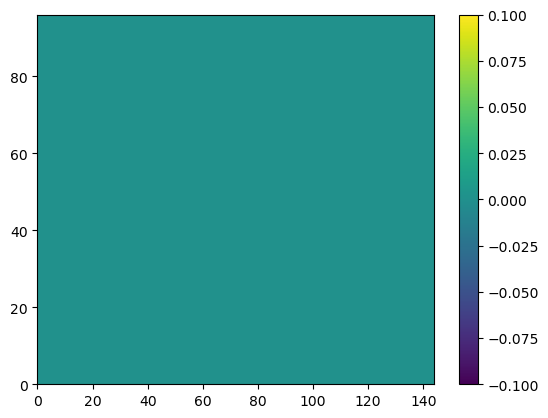

In [47]:
plt.pcolormesh(q98)
plt.colorbar()
plt.show()

In [ ]:
cat1 = col.search(source_id=['NorESM2-LM'], experiment_id=['ssp245'], table_id=['day'], variable_id=['hus','va'], member_id=['r1i1p1f1'])
cat1.df
dset_dict1 = cat1.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dataset_list1 = list(dset_dict1.keys())
dset1 = dset_dict1[dataset_list1[0]]
dset1 = dset1.sel(member_id='r1i1p1f1',time=slice("2020-01-01", "2020-12-31"))
dset1